<a href="https://colab.research.google.com/github/DaniellePotts/Sentiment-Analysis-with-QReLU-and-mQReLU/blob/main/sentiments_140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contractions

     |████████████████████████████████| 321 kB 7.7 MB/s 
     |████████████████████████████████| 283 kB 63.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85440 sha256=e4cdb5c025b178bbb8e156a9fab9948d274641c5c9edf7af09a5517b517b3e4f
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 7.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [15]:
%tensorflow_version 1.x 
import tensorflow as tf

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import spacy
import re
import unicodedata
import nltk
nltk.download('stopwords')
import contractions
from collections import Counter
from nltk.tokenize.toktok import ToktokTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [4]:
cols = ['sentiment','id','date','query_string','user','text']

In [5]:
df = pd.read_csv("./training.csv",header=None, names=cols,  engine='python')

In [6]:
df.shape

(1600000, 6)

In [7]:
df['sentiment'].unique()

array([0, 4])

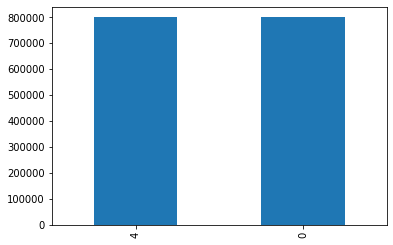

In [8]:
df['sentiment'].value_counts().plot.bar()

In [9]:
sentiments_cat = ['negative','neutral','postive']

In [23]:
def encode_corpus(corpus):
  words = ' '.join(corpus).split()
  
  count_words = Counter(words)
  total_words = len(words)

def count_words(corpus):
  words = ' '.join(corpus).split()
  
  counted_words = Counter(words)
  total_words = len(words)

  return total_words, counted_words

def sort_words(corpus):
  total_words, counted_words = count_words(corpus)
  return counted_words.most_common(total_words)

def decode_sentiments(encoded_sentiments, sentiments_cat=sentiments_cat, postive_index=2, 
                      negative_index=0, neutral_index=1):
  decoded_sentiments = []

  for index in range(0, len(encoded_sentiments)):
    if encoded_sentiments[index] == 0:
      decoded_sentiments.append(sentiments_cat[negative_index])
    elif encoded_sentiments[index] == 2:
      decoded_sentiments.append(sentiments_cat[neutral_index])
    elif encoded_sentiments[index] == 4 or encoded_sentiments[index] == 1:
      decoded_sentiments.append(sentiments_cat[postive_index])
  
  return decoded_sentiments

def convert_sentiments(sentiments):
  converted = []

  for s in sentiments:
    if s == 4:
      converted.append(1)
    else:
      converted.append(0)
  return np.array(converted)

In [17]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def convert_to_lower(corpus):
    return [c.lower() for c in corpus]
    
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def expand_contractions(text):
  expanded_words = []    
  for word in text.split():
    # using contractions.fix to expand the shotened words
    expanded_words.append(contractions.fix(word))   
      
  return' '.join(expanded_words)

In [18]:
sentiments = convert_sentiments(df['sentiment'].values)

In [19]:
sentiments = convert_sentiments(df['sentiment'].values)
corpus = convert_to_lower(df['text'].values)

In [20]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        # lemmatize text
        # if text_lemmatization:
        #     doc = lemmatize_text(doc)
        
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
            
            pat1 = r'@[A-Za-z0-9_]+'
            pat2 = r'https?://[^ ]+'
            www_pat = r'www.[^ ]+'
            combined_pat = r'|'.join((pat1, pat2))
            doc = re.sub(combined_pat, '', doc)
            doc = re.sub(www_pat, '', doc)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [21]:
normalized_corpus = normalize_corpus(corpus)

In [24]:
total_words = count_words(normalized_corpus)
sorted_words = sort_words(normalized_corpus)

In [25]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [ ]:
vocab_to_int

In [29]:
def tokenize(corpus):
  reviews_int = []
  for review in corpus:
      r = [vocab_to_int[w] for w in review.split()]
      reviews_int.append(r)
  return reviews_int

In [36]:
encoded = tokenize(normalized_corpus)
encoded_np = np.array(encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [47]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

In [53]:
VOCAB_SIZE = 12167406
MAXLEN = 100

X_train, X_test, y_train, y_test = train_test_split(
    encoded, sentiments, test_size=0.33, random_state=42)
#we cannot pass different length data to the model, thus all must be the same so we normalise them with MAXLEN
#if the review is > maxlen, trim it, if not pad it with 0s 
X_train = sequence.pad_sequences(X_train, MAXLEN)
X_test = sequence.pad_sequences(X_test, MAXLEN)

In [55]:
len(X_train), len(X_test)

(1072000, 528000)

In [56]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 96113,   529,     1,     2,   836,
           9], dtype=int32)

In [57]:
"""Additional utility for Deep Learning models in TensorFlow and Keras"""

# The Quantum ReLU or 'QReLU' as a custom activation function in TensorFlow (tf_q_relu)
# and Keras (QReLU)

# Author: Luca Parisi <luca.parisi@ieee.org>


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer


# QReLU as a custom activation function in TensorFlow

'''
# Example of usage of the QReLU in TensorFlow as a custom activation function of a convolutional layer (#2)

convolutional_layer_2 = tf.layers.conv2d(
                        inputs=pooling_layer_1,
                        filters=64,
                        kernel_size=[5, 5],
                        padding="same")
convolutional_layer_activation = tf_q_relu(convolutional_layer_2)
pooling_layer_2 = tf.layers.max_pooling2d(inputs=convolutional_layer_activation, pool_size=[2, 2], strides=2)
'''

# Defining the QReLU function
def q_relu(x):
  if x>0:
    x = x
    return x
  else:
    x = 0.01*x-2*x
    return x

# Vectorising the QReLU function  
np_q_relu = np.vectorize(q_relu)

# Defining the derivative of the function QReLU
def d_q_relu(x):
  if x>0:
    x = 1
    return x
  else:
    x = 0.01-2
    return x

# Vectorising the derivative of the QReLU function  
np_d_q_relu = np.vectorize(d_q_relu)

# Defining the gradient function of the QReLU
def q_relu_grad(op, grad):
    x = op.inputs[0]
    n_gr = tf_d_q_relu(x)
    return grad * n_gr

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
# Generating a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+2))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

np_q_relu_32 = lambda x: np_q_relu(x).astype(np.float32)

def tf_q_relu(x,name=None):
    with tf.name_scope(name, "q_relu", [x]) as name:
        y = py_func(np_q_relu_32,   # Forward pass function
                        [x],
                        [tf.float32],
                        name=name,
                         grad= q_relu_grad) # The function that overrides gradient
        y[0].set_shape(x.get_shape())     # To specify the rank of the input.
        return y[0]

np_d_q_relu_32 = lambda x: np_d_q_relu(x).astype(np.float32)

def tf_d_q_relu(x,name=None):
    with tf.name_scope(name, "d_q_relu", [x]) as name:
        y = tf.py_func(np_d_q_relu_32,
                        [x],
                        [tf.float32],
                        name=name,
                        stateful=False)
        return y[0]


# QReLU as a custom layer in Keras 

'''
# Example of usage of the QReLU as a Keras layer in a sequential model between a convolutional layer and a pooling layer

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(QReLU())
model.add(layers.MaxPooling2D((2, 2)))
'''

class QReLU(Layer):

    def __init__(self):
        super(QReLU,self).__init__()

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs,name=None):
        return tf_q_relu(inputs,name=None)

    def get_config(self):
        base_config = super(QReLU, self).get_config()
        return dict(list(base_config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(1),
    QReLU()
])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape 

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=['acc'])

history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 857600 samples, validate on 214400 samples
Epoch 1/5
857600/857600 [==============================] - 4880s 6ms/sample - loss: 7.5831 - acc: 0.5012 - val_loss: 7.6386 - val_acc: 0.4991
Epoch 2/5
857600/857600 [==============================] - 4804s 6ms/sample - loss: 7.6752 - acc: 0.4994 - val_loss: 7.6386 - val_acc: 0.4991
Epoch 3/5
857600/857600 [==============================] - 4804s 6ms/sample - loss: 7.6752 - acc: 0.4994 - val_loss: 7.6386 - val_acc: 0.4991
Epoch 4/5
 85568/857600 [=>............................] - ETA: 1:09:46 - loss: 7.6786 - acc: 0.4992

In [ ]:
results = model.evaluate(X_test, y_test)
print(results)